In [3]:
import kaolin
import torch
import os
import numpy as np
from scipy.spatial import Delaunay
import matplotlib.pyplot as plt
from scipy.spatial import Voronoi, voronoi_plot_2d
from io import BytesIO
from PIL import Image
import sdfpred_utils.sdfpred_utils as su
import sdfpred_utils.sdf_MLP as mlp
import sdfpred_utils.sdf_functions as sdf
import sdfpred_utils.loss_functions as lf

#cuda devices
device = torch.device("cuda:0")
print("Using device: ", torch.cuda.get_device_name(device))

#default tensor types
torch.set_default_tensor_type(torch.cuda.DoubleTensor)

multires = 2
lr_sites = 0.03
lr_model = 0.0003
iterations = 5000
save_every = 100
max_iter = 100
#learning_rate = 0.03
destination = "./images/autograd/multiple_sites/"


Using device:  NVIDIA GeForce RTX 3050 Laptop GPU


In [4]:
sites = su.createCVTgrid()

NameError: name 'device' is not defined

In [194]:
def get_delaunay_neighbors_list(sites):
    # Detach and convert to NumPy for Delaunay triangulation
    points_np = sites.detach().cpu().numpy()
    
    # Compute the Delaunay triangulation
    tri = Delaunay(points_np)

    # Find the neighbors of each point
    neighbors = {i: set() for i in range(len(points_np))}
    for simplex in tri.simplices:
        # Each simplex is a triangle of three points; each point is a neighbor of the other two
        for i in range(3):
            for j in range(i + 1, 3):
                neighbors[simplex[i]].add(simplex[j])
                neighbors[simplex[j]].add(simplex[i])

    # Convert neighbor sets to lists for easier reading
    neighbors = {key: list(value) for key, value in neighbors.items()}
    return neighbors

def compute_vertices_index(neighbors):
    vertices_index_to_compute = []
    for site, adjacents in neighbors.items():
        for i in adjacents:
            for n in adjacents:
                if n != site and n != i and n in neighbors[i]:              
                    vertices_index_to_compute.append([i,site,n])
            
    # Set to store the canonical (sorted) version of each triplet
    seen_triplets = set()
    # Filtered list to store the unique triplets
    filtered_triplets = []
    # Process each triplet and keep only one permutation
    for triplet in vertices_index_to_compute:
        # Convert the triplet to a canonical form by sorting it
        canonical_triplet = tuple(sorted(triplet, key=str))
        # Check if this canonical triplet has been seen before
        if canonical_triplet not in seen_triplets:
            # If not seen, add it to the set and keep the triplet
            seen_triplets.add(canonical_triplet)
            filtered_triplets.append(triplet)

    return filtered_triplets

def compute_zero_crossing_vertices(sites, model):
    """
    Computes the indices of the sites composing vertices where neighboring sites have opposite or zero SDF values.

    Args:
        sites (torch.Tensor): (N, D) tensor of site positions.
        model (callable): Function or neural network that computes SDF values.

    Returns:
        zero_crossing_vertices_index (list of triplets): List of sites indices (si, sj, sk) where atleast 2 sites have opposing SDF signs.
    """
    # Compute Delaunay neighbors
    neighbors = get_delaunay_neighbors_list(sites)

    # Compute SDF values for all sites
    sdf_values = model(sites)  # Assuming model outputs (N, 1) or (N,) tensor

    # Find pairs of neighbors with opposing SDF values
    zero_crossing_pairs = set()
    for i, adjacents in neighbors.items():
        for j in adjacents:
            if i < j:  # Avoid duplicates
                sdf_i, sdf_j = sdf_values[i].item(), sdf_values[j].item()
                if sdf_i * sdf_j <= 0:  # Opposing signs or one is zero
                    zero_crossing_pairs.add((i, j))
    

    # Compute vertices (triplets) and filter only those involving zero-crossing pairs
    all_vertices = compute_vertices_index(neighbors)
    zero_crossing_vertices_index = []
    
    for triplet in all_vertices:
        triplet_pairs = {(triplet[0], triplet[1]), (triplet[1], triplet[2]), (triplet[0], triplet[2])}
        if any(pair in zero_crossing_pairs for pair in triplet_pairs):
            zero_crossing_vertices_index.append(triplet)

    return zero_crossing_vertices_index, zero_crossing_pairs

def compute_vertex(s_i, s_j, s_k):
    # Unpack coordinates for each site
    x_i, y_i = s_i[0], s_i[1]
    x_j, y_j = s_j[0], s_j[1]
    x_k, y_k = s_k[0], s_k[1]
    
    # Calculate numerator and  for x coordinate
    n_x = (
        x_i**2 * (y_j - y_k)
        - x_j**2 * (y_i - y_k)
        + (x_k**2 + (y_i - y_k) * (y_j - y_k)) * (y_i - y_j)
    )

    # Calculate numerator for y coordinate
    n_y = -(
        x_i**2 * (x_j - x_k)
        - x_i * (x_j**2 - x_k**2 + y_j**2 - y_k**2)
        + x_j**2 * x_k
        - x_j * (x_k**2 - y_i**2 + y_k**2)
        - x_k * (y_i**2 - y_j**2)
    )
    
    # Calculate denominator 
    d = 2 * (x_i * (y_j - y_k) - x_j * (y_i - y_k) + x_k * (y_i - y_j))
    
    # Calculate x and y coordinates
    x = n_x / d
    y = n_y / d

    # Return x, y as a tensor to maintain the computational graph
    return torch.stack([x, y])

def compute_all_vertices(sites, vertices_to_compute):
    # Initialize an empty tensor for storing vertices
    vertices = []
    
    for triplet in vertices_to_compute:
        si = sites[triplet[0]]
        sj = sites[triplet[1]]
        sk = sites[triplet[2]]
        
        # Compute vertex for the triplet (si, sj, sk)
        v = compute_vertex(si, sj, sk)
        
        # Append to the list
        vertices.append(v)
    
    # Stack the list of vertices into a single tensor for easier gradient tracking
    vertices = torch.stack(vertices)
    return vertices

def compute_all_bisectors(sites, bisectors_to_compute):
    # Initialize an empty tensor for storing bisectors
    bisectors = []
    
    for pairs in bisectors_to_compute:
        si = sites[pairs[0]]
        sj = sites[pairs[1]]
        b = (si + sj) / 2
        bisectors.append(b)

    # Stack the list of bisectors into a single tensor for easier gradient tracking
    bisectors = torch.stack(bisectors)
    return bisectors
    

def upsampling_inside(sites, model):
    # Compute SDF values for each site
    sdf_values = model(sites)
    sdf_values = sdf_values.detach().cpu().numpy()
    
    sites_np = sites.detach().cpu().numpy()
    # Compute Voronoi diagram
    vor = Voronoi(sites_np)
    
    #edges = []
    negative_sites = np.array([]).reshape(0,2)

    for (point1, point2), (vertex1, vertex2) in zip(vor.ridge_points, vor.ridge_vertices):
        # Check if vertices are valid (not -1, which indicates infinity)
        if vertex1 == -1 or vertex2 == -1:
            continue
        
        # Check if the sites have different signs
        if np.sign(sdf_values[point1]) != np.sign(sdf_values[point2]):
            #edges.append((vertex1, vertex2))
            
            # Append the site with a negative SDF value
            # if sdf_values[point1] < 0 and not np.any([np.array_equal(sites_np[point1], site) for site in negative_sites]):
            #     negative_sites = np.concatenate((negative_sites, [sites_np[point1]]), axis=0)
            # if sdf_values[point2] < 0 and not np.any([np.array_equal(sites_np[point2], site) for site in negative_sites]):
            #     negative_sites = np.concatenate((negative_sites, [sites_np[point2]]), axis=0)
            
            # Append the site 
            #todo rename negative_sites
            if not np.any([np.array_equal(sites_np[point1], site) for site in negative_sites]):
                negative_sites = np.concatenate((negative_sites, [sites_np[point1]]), axis=0)
            if not np.any([np.array_equal(sites_np[point2], site) for site in negative_sites]):
                negative_sites = np.concatenate((negative_sites, [sites_np[point2]]), axis=0)
                
    new_sites = []
    
    for i, region_index in enumerate(vor.point_region):
        if sites_np[i] in negative_sites:
            current_site = sites[i]
            region = vor.regions[region_index]
            if -1 in region or len(region) == 0:  # Skip infinite or empty regions
                continue
        
            # Get vertices of the cell
            vertices = vor.vertices[region]
            vertices = torch.from_numpy(vor.vertices[region]).to(device)
            
            smallest_edge_length = float("inf")
            for j in range(len(vertices)):
                v1, v2 = vertices[j], vertices[(j + 1) % len(vertices)]
                # Compute edge length
                edge_length = torch.norm(v2 - v1)
                smallest_edge_length = min(smallest_edge_length, edge_length)

            # Calculate the distance from the barycenter to the vertices (circumradius)
            rad = smallest_edge_length / np.sqrt(3)  # For equilateral triangle, circumradius = edge / sqrt(3)

            # Define 3 angles for the triangle vertices, spaced 120 degrees apart
            angles = torch.tensor([0, 2 * np.pi / 3, 4 * np.pi / 3], device=device)
                
            # Calculate the offset vectors for each vertex around the barycenter
            offsets = torch.stack([torch.cos(angles), torch.sin(angles)], dim=1) * rad
                
            # Generate new sites by adding the offsets to the current site
            for offset in offsets:
                new_sites.append(current_site + offset)

    return new_sites
                
def add_upsampled_sites(sites, new_sites, min_distance=0.01):
    """
    Add new sites while ensuring a minimum distance between points.
    Parameters:
        sites (torch.Tensor): Existing sites, shape (N, 2).
        new_sites (torch.Tensor): New candidate sites, shape (M, 2).
        min_distance (float): Minimum allowable distance between sites.
    Returns:
        torch.Tensor: Updated set of sites.
    """
    #updated_sites = sites.clone()  # Clone the existing tensor to modify later
    updated_sites = sites
    
    for new_site in new_sites:
        # Compute distances between the new site and all existing sites
        distances = torch.norm(updated_sites - new_site, dim=1)
        # Check if the new site is far enough from all existing sites
        if torch.all(distances > min_distance):
            #print(f"Adding new site at {new_site}")
            updated_sites = torch.cat((updated_sites, new_site.unsqueeze(0)), dim=0)

    return updated_sites

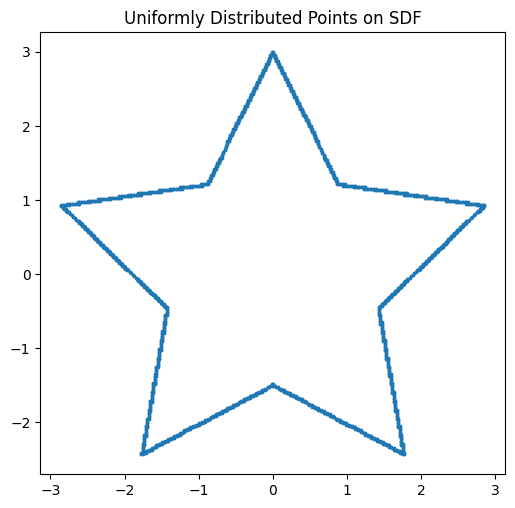

Points shape:  torch.Size([1286, 2])


In [ ]:
# Generate points
#true_points = generate_rectangle_points(num_points=400, width=1.0, height=1.0, scale=6.0)

sdf_function = sdf.star_sdf

true_points = sdf.generate_sdf_points(grid_size=1000, width=20.0, height=20.0, sdf_function=sdf_function, threshold=13e-3)

if sdf_function == sdf.bunny_sdf:
    #shift points to the center
    true_points = true_points - torch.tensor([2,2])
    true_points = true_points * 1.5

if sdf_function == sdf.moon_sdf:
    true_points = true_points + torch.tensor([2,0])
    

# Plot points
plt.figure(figsize=(6, 6))
plt.axes().set_aspect('equal')
plt.scatter(true_points[:, 0].cpu(), true_points[:, 1].cpu(), s=3)
plt.title("Uniformly Distributed Points on SDF")

plt.show()

print("Points shape: ", true_points.shape)



loaded model


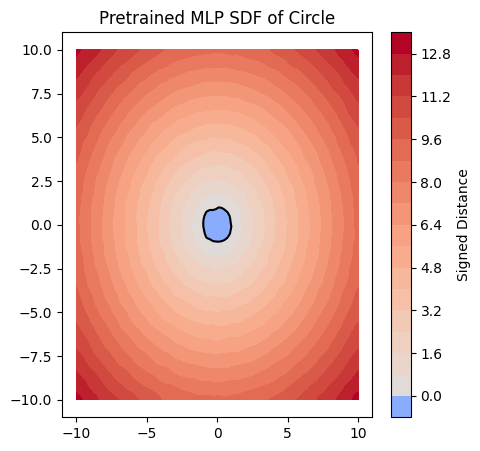

In [ ]:
import matplotlib
import os

model = mlp.Decoder(multires=multires).to(device)
model_path = 'pretrained_circle_small.pth'
if os.path.exists(model_path):
    model.load_state_dict(torch.load(model_path))
    print('loaded model')
else:
    print("no model found, pretraining")
    model.pre_train_circle(3000, radius=1.0)
    torch.save(model.state_dict(),model_path)

#plot sdf_circle_wave
fig, ax = plt.subplots(figsize=(5, 5))
xx, yy, sdf_values = sdf.plot_sdf(ax, model)

#convert sdf to numpy
sdf_values = sdf_values.cpu().detach().numpy()

norm = matplotlib.colors.TwoSlopeNorm(vmin=np.min(sdf_values), vcenter=0, vmax=np.max(sdf_values))

# Plot the SDF with the centered colormap
contour = plt.contourf(xx, yy, sdf_values, levels=20, cmap="coolwarm", norm=norm)

# Add a colorbar with label
plt.colorbar(contour, label="Signed Distance")
plt.title("Pretrained MLP SDF of Circle")
plt.xlim(-11, 11)
plt.ylim(-11, 11)

plt.show()


In [197]:
cvt_loss_values = []
min_distance_loss_values = []
edge_smoothing_loss_values = []
chamfer_distance_loss_values = []
eikonal_loss_values = []
domain_restriction_loss_values = []
zero_true_points_loss_values = []
loss_values = []

def autograd(sites, model, max_iter=100, stop_train_threshold=1e-6, upsampling=0, lambda_weights = [0.1,1.0,0.1,0.1,1.0,1.0,0.1]):
    optimizer = torch.optim.Adam([
    {'params': [p for _, p in model.named_parameters()], 'lr': lr_model},
    {'params': [sites], 'lr': lr_sites}
], betas=(0.5, 0.999))

    prev_loss = float("inf")
    best_loss = float("inf")
    upsampled = 0.0
    epoch = 0
    lambda_cvt = lambda_weights[0]
    lambda_sdf = lambda_weights[1]
    lambda_min_distance = lambda_weights[2]
    lambda_laplace = lambda_weights[3]
    lamda_chamfer = lambda_weights[4]
    lamda_eikonal = lambda_weights[5]
    lambda_domain_restriction = lambda_weights[6]
    lambda_true_points = lambda_weights[7]
    
    
    
    best_sites = sites.clone()
    best_sites.best_loss = best_loss
    
    gif_frames = []  # List to store individual frames for GIF
    gif_fn = f'{destination}{max_iter}_cvt_{lambda_cvt}_sdf_{lambda_sdf}_min_distance_{lambda_min_distance}_laplace_{lambda_laplace}_chamfer_{lamda_chamfer}.gif'
    fig, ax = plt.subplots(figsize=(5, 5))  # Create a single figure
    last_edges = torch.tensor([])
    last_random_points = torch.tensor([])
    
    while epoch <= max_iter:
        optimizer.zero_grad()
        
        vertices_to_compute, bisectors_to_compute = compute_zero_crossing_vertices(sites, model)
        vertices = compute_all_vertices(sites, vertices_to_compute)
        bisectors = compute_all_bisectors(sites, bisectors_to_compute)
    
        
        #combine vertices and bisectors to one tensor for chamfer
        points = torch.cat((vertices, bisectors), 0)
        #points = bisectors        

        
        # Compute losses       
        cvt_loss = lf.compute_cvt_loss(sites)
        #min_distance_loss = min_distance_regularization_for_op_sites(edges,sites)
        min_distance_loss = lf.sdf_weighted_min_distance_loss(model, sites)
        #edge_smoothing_loss = compute_edge_smoothing_loss(edges, sites, model)
        chamfer_loss = lf.chamfer_distance(true_points, points)
        eikonal_loss = lf.eikonal(model)
        domain_restriction_loss = lf.domain_restriction(true_points, model)
        
        sdf_values_true_points = model(true_points)[:,0]
        zero_true_points_loss_L2 = torch.mean(sdf_values_true_points**2)
        zero_true_points_loss_L1 = torch.mean(torch.abs(model(true_points)[:, 0]))
        lambda_1, lambda_2 = 0 , 0.99  # Adjust weights as needed
        zero_true_points_loss = lambda_1 * zero_true_points_loss_L1 + lambda_2 * zero_true_points_loss_L2

               
        # Track raw losses (unweighted)
        cvt_loss_values.append(cvt_loss.item())
        min_distance_loss_values.append(min_distance_loss.item())
        #edge_smoothing_loss_values.append(edge_smoothing_loss.item())
        chamfer_distance_loss_values.append(chamfer_loss.item())
        eikonal_loss_values.append(eikonal_loss.item())
        domain_restriction_loss_values.append(domain_restriction_loss.item())
        zero_true_points_loss_values.append(zero_true_points_loss.item())
  
        loss = (
            lambda_cvt * cvt_loss +
            lambda_min_distance * min_distance_loss + 
            #lambda_laplace * edge_smoothing_loss +
            lamda_chamfer * chamfer_loss +
            lamda_eikonal * eikonal_loss +
            lambda_domain_restriction * domain_restriction_loss +
            lambda_true_points * zero_true_points_loss
        )
        loss_values.append(loss.item())
        print(f"Epoch {epoch}: loss = {loss.item()}")
                
        loss.backward()
        optimizer.step()
        
        if loss.item() < best_loss:
            best_loss = loss.item()
            best_epoch = epoch
            best_sites = sites.clone()
            best_sites.best_loss = best_loss
            if upsampled > 0:
                print(f"UPSAMPLED {upsampled} Best Epoch {best_epoch}: Best loss = {best_loss}")
                #return best_sites
        
        if abs(prev_loss - loss.item()) < stop_train_threshold:
            print(f"Converged at epoch {epoch} with loss {loss.item()}")
            #break
        
        prev_loss = loss.item() 
               
        #if epoch>100 and epoch%100 == 1 and upsampled < 2:
        if epoch>100 and (epoch // 100) == upsampled+1 and loss.item() < 0.5 and upsampled < upsampling:
            print("sites length: ",len(sites))
            new_sites = upsampling_inside(best_sites, model)
            print(new_sites)
            sites = add_upsampled_sites(best_sites, new_sites)
            sites = sites.detach().requires_grad_(True)
            print("upsampled sites length: ",len(sites))
            
            best_sites = sites.clone()
            best_sites.best_loss = best_loss
            
            optimizer = torch.optim.Adam([{'params': [p for _, p in model.named_parameters()], 'lr': lr_model},
                                          {'params': [sites], 'lr': lr_sites}])
            upsampled += 1.0

        # Plot Voronoi diagram
        sites_np = sites.detach().cpu().numpy()
        voronoi_initial = Voronoi(sites_np)
        ax.clear()  # Clear the current plot
        voronoi_plot_2d(voronoi_initial, ax=ax, show_vertices=False, line_colors='blue')
        xx, yy, sdf_values = sdf.plot_sdf(ax, model)

        #convert sdf to numpy
        sdf_values = sdf_values.cpu().detach().numpy()

        norm = matplotlib.colors.TwoSlopeNorm(vmin=np.min(sdf_values), vcenter=0, vmax=np.max(sdf_values))

        # Plot the SDF with the centered colormap
        contour = plt.contourf(xx, yy, sdf_values, levels=20, cmap="coolwarm", norm=norm)

        ax.scatter(true_points[:,0].cpu(), true_points[:,1].cpu(), color='green', s=1)

        #plot vertices
        ax.scatter(vertices[:,0].detach().cpu().numpy(), vertices[:,1].detach().cpu().numpy(), color='red', s=30)
        ax.scatter(bisectors[:,0].detach().cpu().numpy(), bisectors[:,1].detach().cpu().numpy(), color='yellow', s=30)
      
        ax.set_title(f"Epoch {epoch} - Loss: {loss:.4f}")
        
        # Save the current figure to an in-memory buffer
        buf = BytesIO()
        plt.savefig(buf, format='png')
        buf.seek(0)
        
        # Append the buffer content as an image frame
        gif_frames.append(Image.open(buf))
                        
        if epoch % (max_iter/10) == 0:
            print(f"Epoch {epoch}: loss = {loss.item()}")
            print(f"Best Epoch {best_epoch}: Best loss = {best_loss}")
            # Save the GIF
            gif_frames[0].save(
                f'{destination}{max_iter}_{epoch}_cvt_{lambda_cvt}_sdf_{lambda_sdf}_min_distance_{lambda_min_distance}_laplace_{lambda_laplace}_chamfer_{lamda_chamfer}.gif',
                save_all=True,            
                append_images=gif_frames[1:],
                duration=100,  # Duration in ms between frames
                loop=0
            )
            print("GIF saved as ",f'{destination}{max_iter}_{epoch}_cvt_{lambda_cvt}_sdf_{lambda_sdf}_min_distance_{lambda_min_distance}_laplace_{lambda_laplace}_chamfer_{lamda_chamfer}.gif',
)
                    
        epoch += 1
            
    # Save the GIF
    gif_frames[0].save(
        gif_fn,
        save_all=True,
        append_images=gif_frames[1:],
        duration=100,  # Duration in ms between frames
        loop=0
    )
    print("GIF saved as ", gif_fn)
            
        
    return best_sites

Epoch 0: loss = 56.79564540046626
Epoch 0: loss = 56.79564540046626
Best Epoch 0: Best loss = 56.79564540046626
GIF saved as  ./images/autograd/multiple_sites/500_0_cvt_0.2_sdf_0_min_distance_0.1_laplace_0_chamfer_1.0021111111111112.gif
Epoch 1: loss = 212.45824758906986
Epoch 2: loss = 296.00424110259104
Epoch 3: loss = 263.34680958406875
Epoch 4: loss = 1122.5705877476055
Epoch 5: loss = 38.90551057765533
Epoch 6: loss = 5.654321862469441
Epoch 7: loss = 2.2672709665260267
Epoch 8: loss = 337.34715327853996
Epoch 9: loss = 2.6815250769341676
Epoch 10: loss = 2.747929495856832
Epoch 11: loss = 0.7317541829178839
Epoch 12: loss = 36.5894421998316
Epoch 13: loss = 53.23748429461332
Epoch 14: loss = 925.5575523229776
Epoch 15: loss = 2.1845122611244983
Epoch 16: loss = 1.0716859873964855
Epoch 17: loss = 17.145324119751205
Epoch 18: loss = 20.652050442445407
Epoch 19: loss = 40491.895424816124
Epoch 20: loss = 233.3280378998752
Epoch 21: loss = 1.704872988695186
Epoch 22: loss = 91248.57

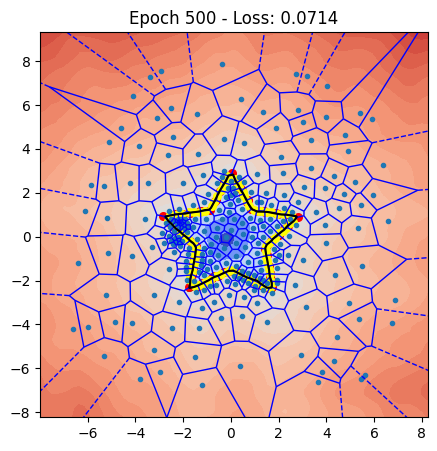

In [ ]:
lambda_weights = [0.2,0,0.1,0,1.0021111111111111,0.1,0,2]

lambda_cvt = lambda_weights[0]
lambda_sdf = lambda_weights[1]
lambda_min_distance = lambda_weights[2]
lambda_laplace = lambda_weights[3]
lamda_chamfer = lambda_weights[4]
lambda_eikonal = lambda_weights[5]
lambda_domain_restriction = lambda_weights[6]
lambda_true_points = lambda_weights[7]

max_iter = 500

site_file_path = f'{destination}{max_iter}_cvt_{lambda_cvt}_sdf_{lambda_sdf}_min_distance_{lambda_min_distance}_laplace_{lambda_laplace}_chamfer_{lamda_chamfer}_eikonal_{lambda_eikonal}.npy'
#check if optimized sites file exists
if os.path.exists(site_file_path):
    #import sites
    print("Importing sites")
    sites = np.load(site_file_path)
    sites = torch.from_numpy(sites).to(device).requires_grad_(True)
    #load model from file
    model = mlp.Decoder(multires=multires).to(device)
    model.load_state_dict(torch.load(f'{destination}{max_iter}_cvt_{lambda_cvt}_sdf_{lambda_sdf}_min_distance_{lambda_min_distance}_laplace_{lambda_laplace}_chamfer_{lamda_chamfer}_eikonal_{lambda_eikonal}.pth'))   
    
else:
    sites = autograd(sites, model, max_iter=max_iter, upsampling=1, lambda_weights=lambda_weights)
    sites_np = sites.detach().cpu().numpy()
    np.save(site_file_path, sites_np)
    #save model
    torch.save(model.state_dict(), f'{destination}{max_iter}_cvt_{lambda_cvt}_sdf_{lambda_sdf}_min_distance_{lambda_min_distance}_laplace_{lambda_laplace}_chamfer_{lamda_chamfer}_eikonal{lambda_eikonal}.pth')


#print("Sites: ", sites)

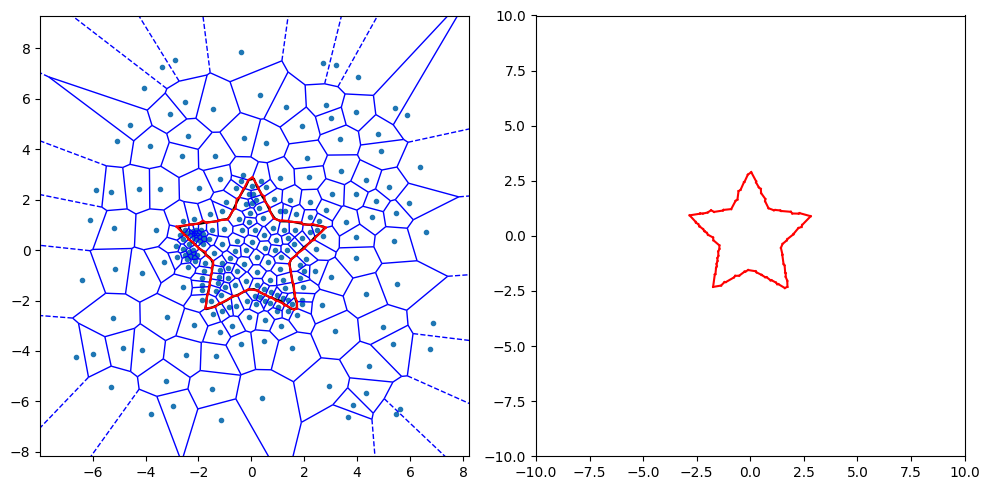

In [199]:
def get_sites_zero_crossing_edges(sites, model):
    sites_np = sites.detach().cpu().numpy()
    # Compute Voronoi diagram
    vor = Voronoi(sites_np)

    # Compute SDF values for each site
    sdf_values = model(sites)[:,0]
    sdf_values = sdf_values.detach().cpu().numpy()

    edges = []
    for (point1, point2), (vertex1, vertex2) in zip(vor.ridge_points, vor.ridge_vertices):
        # Check if vertices are valid (not -1, which indicates infinity)
        if vertex1 == -1 or vertex2 == -1:
            continue
        
        # Check if the sites have different signs
        if np.sign(sdf_values[point1]) != np.sign(sdf_values[point2]):
            edges.append((vertex1, vertex2))
    
    
        # Create two subplots: one with Voronoi diagram and one without
    fig, axs = plt.subplots(1, 2, figsize=(10, 5))

    # Plot with Voronoi diagram
    ax1 = axs[0]
    voronoi_plot_2d(vor, ax=ax1, show_vertices=False, line_colors='blue')
    plot_sdf(ax1, model)

    #ax1.set_title("With Voronoi Diagram")

    # Plot edges
    for vertex1, vertex2 in edges:
        v1 = vor.vertices[vertex1]
        v2 = vor.vertices[vertex2]
        ax1.plot([v1[0], v2[0]], [v1[1], v2[1]], 'r-')

    #ax1.legend(['Zero-crossing edges'], loc='upper right')

    # Plot without Voronoi diagram
    ax2 = axs[1]
    #plot_sdf(ax2, model)

    #ax2.set_title("Without Voronoi Diagram")
    #plt.triplot(*zip(*sites_np), 'o', markersize=3, color='blue')

    # Plot edges
    for vertex1, vertex2 in edges:
        v1 = vor.vertices[vertex1]
        v2 = vor.vertices[vertex2]
        ax2.plot([v1[0], v2[0]], [v1[1], v2[1]], 'r-')

    #ax2.legend(['Zero-crossing edges'], loc='upper right')
    # plt.plot([], [], 'r-', label='sites zero-crossing edge')
    # limit of the plot
    plt.xlim(-10, 10)
    plt.ylim(-10, 10)
    plt.tight_layout()
    plt.savefig(f'{destination}edge_sdf_crossing.png')
    
    plt.show()            
            
    return edges


edges = get_sites_zero_crossing_edges(sites, model)



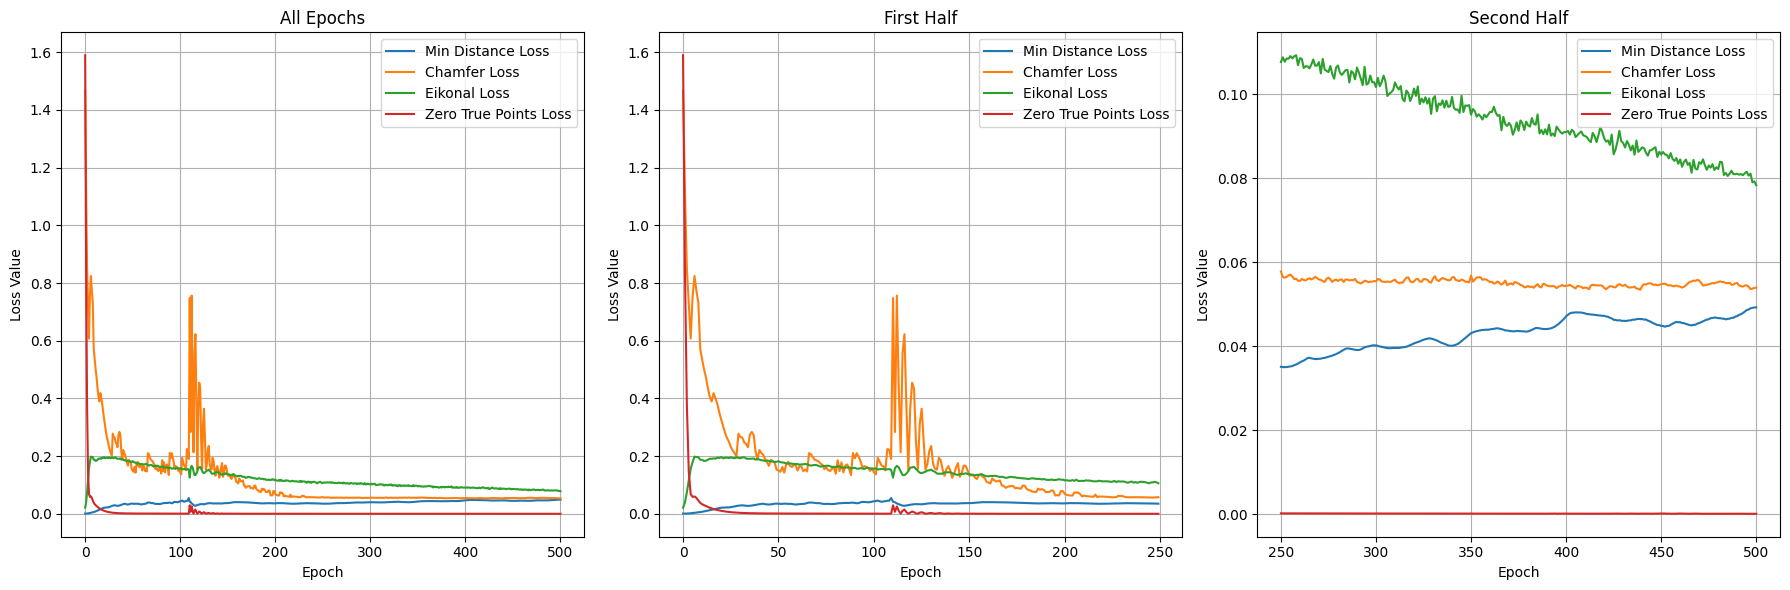

In [200]:
# Define the total number of epochs and split into halves
total_epochs = len(chamfer_distance_loss_values)
half_epoch = total_epochs // 2

# Create a figure with 3 subplots (1 row, 3 columns)
fig, axes = plt.subplots(1, 3, figsize=(18, 6))

# Plot all epochs (x-axis from 0 to 80)
#axes[0].plot(range(total_epochs), sdf_loss_values, label="SDF Loss")
#axes[0].plot(range(total_epochs), cvt_loss_values, label="CVT Loss")
axes[0].plot(range(total_epochs), min_distance_loss_values, label="Min Distance Loss")
#axes[0].plot(range(total_epochs), edge_smoothing_loss_values, label="Edge Smoothing Loss")
axes[0].plot(range(total_epochs), chamfer_distance_loss_values, label="Chamfer Loss")
axes[0].plot(range(total_epochs), eikonal_loss_values, label="Eikonal Loss")
#axes[0].plot(range(total_epochs), domain_restriction_loss_values, label="Domain Restriction Loss")
axes[0].plot(range(total_epochs), zero_true_points_loss_values, label="Zero True Points Loss")

#axes[0].set_xlim(0, 80)  # Set x-axis range from 0 to 80
axes[0].set_title("All Epochs")
axes[0].set_xlabel("Epoch")
axes[0].set_ylabel("Loss Value")
axes[0].legend()
axes[0].grid(True)


# Plot first half 
#axes[1].plot(range(half_epoch), sdf_loss_values[:half_epoch], label="SDF Loss")
#axes[1].plot(range(half_epoch), cvt_loss_values[:half_epoch], label="CVT Loss")
axes[1].plot(range(half_epoch), min_distance_loss_values[:half_epoch], label="Min Distance Loss")
#axes[1].plot(range(half_epoch), edge_smoothing_loss_values[:half_epoch], label="Edge Smoothing Loss")
axes[1].plot(range(half_epoch), chamfer_distance_loss_values[:half_epoch], label="Chamfer Loss")
axes[1].plot(range(half_epoch), eikonal_loss_values[:half_epoch], label="Eikonal Loss")
#axes[1].plot(range(half_epoch), domain_restriction_loss_values[:half_epoch], label="Domain Restriction Loss")
axes[1].plot(range(half_epoch), zero_true_points_loss_values[:half_epoch], label="Zero True Points Loss")

axes[1].set_title("First Half")
axes[1].set_xlabel("Epoch")
axes[1].set_ylabel("Loss Value")
axes[1].legend()
axes[1].grid(True)

# Plot second half 
#axes[2].plot(range(half_epoch, total_epochs), sdf_loss_values[half_epoch:], label="SDF Loss")
#axes[2].plot(range(half_epoch, total_epochs), cvt_loss_values[half_epoch:], label="CVT Loss")
axes[2].plot(range(half_epoch, total_epochs), min_distance_loss_values[half_epoch:], label="Min Distance Loss")
#axes[2].plot(range(half_epoch, total_epochs), edge_smoothing_loss_values[half_epoch:], label="Edge Smoothing Loss")
axes[2].plot(range(half_epoch, total_epochs), chamfer_distance_loss_values[half_epoch:], label="Chamfer Loss")
axes[2].plot(range(half_epoch, total_epochs), eikonal_loss_values[half_epoch:], label="Eikonal Loss")
#axes[2].plot(range(half_epoch, total_epochs), domain_restriction_loss_values[half_epoch:], label="Domain Restriction Loss")
axes[2].plot(range(half_epoch, total_epochs), zero_true_points_loss_values[half_epoch:], label="Zero True Points Loss")

axes[2].set_title("Second Half")
axes[2].set_xlabel("Epoch")
axes[2].set_ylabel("Loss Value")
axes[2].legend()
axes[2].grid(True)

# Adjust layout to prevent overlap
plt.tight_layout()

# Show the plots
plt.show()


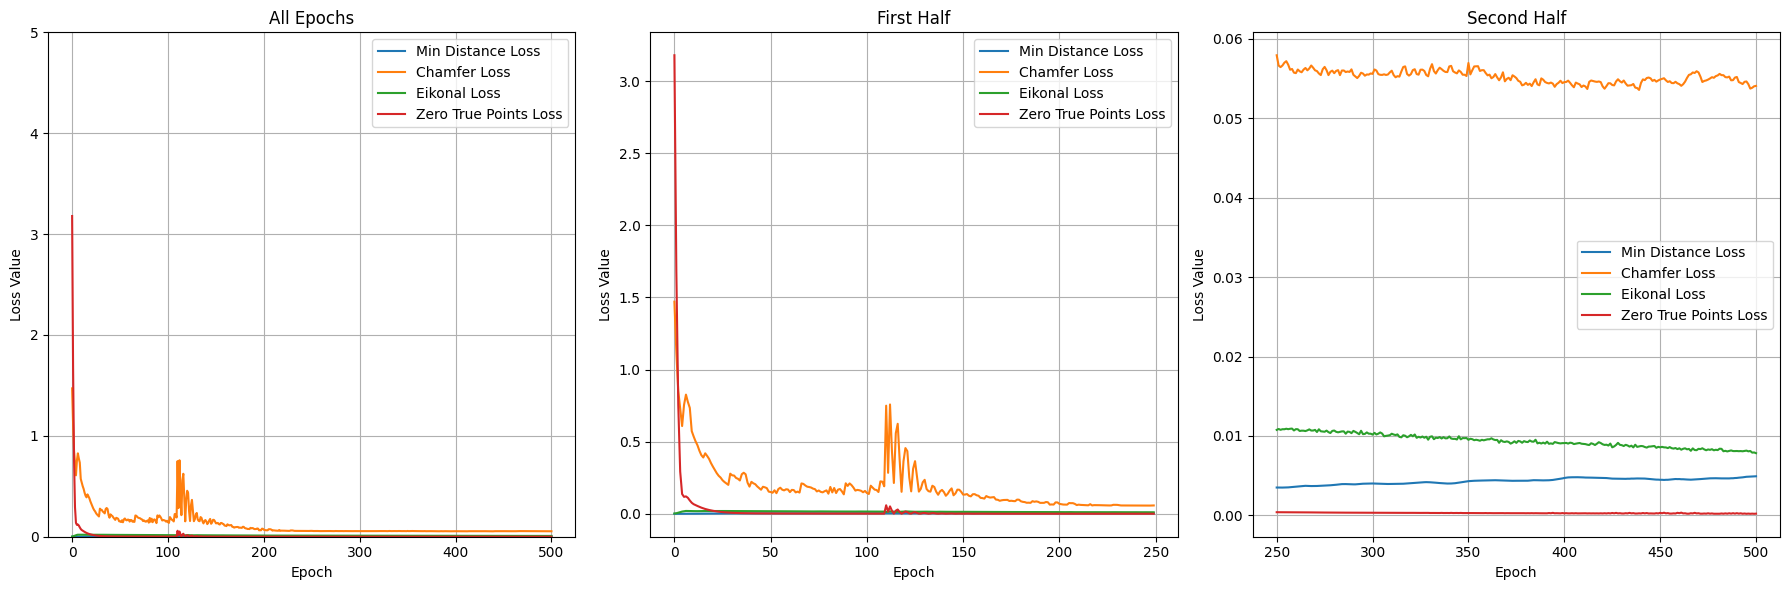

In [201]:
lambda_cvt = lambda_weights[0]
lambda_sdf = lambda_weights[1]
lambda_min_distance = lambda_weights[2]
lambda_laplace = lambda_weights[3]
lambda_chamfer = lambda_weights[4]
lambda_eikonal = lambda_weights[5]
lambda_domain_restriction = lambda_weights[6]
    
# Define the total number of epochs and split into halves
total_epochs = len(chamfer_distance_loss_values)
half_epoch = total_epochs // 2

# Create a figure with 3 subplots (1 row, 3 columns)
fig, axes = plt.subplots(1, 3, figsize=(18, 6))

# Plot all epochs (x-axis from 0 to 80)
#axes[0].plot(range(total_epochs), [x*lambda_sdf for x in sdf_loss_values], label="SDF Loss")
#axes[0].plot(range(total_epochs), [x*lambda_cvt for x in cvt_loss_values], label="CVT Loss")
axes[0].plot(range(total_epochs), [x*lambda_min_distance for x in min_distance_loss_values], label="Min Distance Loss")
#axes[0].plot(range(total_epochs), [x*lambda_laplace for x in edge_smoothing_loss_values], label="Edge Smoothing Loss")
axes[0].plot(range(total_epochs), [x*lambda_chamfer for x in chamfer_distance_loss_values], label="Chamfer Loss")
axes[0].plot(range(total_epochs), [x*lambda_eikonal for x in eikonal_loss_values], label="Eikonal Loss")
#axes[0].plot(range(total_epochs), [x*lambda_domain_restriction for x in domain_restriction_loss_values], label="Domain Restriction Loss")
axes[0].plot(range(total_epochs), [x*lambda_true_points for x in zero_true_points_loss_values], label="Zero True Points Loss")

#axes[0].set_xlim(0, 80)  # Set x-axis range from 0 to 80
axes[0].set_ylim(0, 5)

axes[0].set_title("All Epochs")
axes[0].set_xlabel("Epoch")
axes[0].set_ylabel("Loss Value")
axes[0].legend()
axes[0].grid(True)


# Plot first half 
#axes[1].plot(range(half_epoch), [x*lambda_sdf for x in sdf_loss_values[:half_epoch]], label="SDF Loss")
#axes[1].plot(range(half_epoch), [x*lambda_cvt for x in cvt_loss_values[:half_epoch]], label="CVT Loss")
axes[1].plot(range(half_epoch), [x*lambda_min_distance for x in min_distance_loss_values[:half_epoch]], label="Min Distance Loss")
#axes[1].plot(range(half_epoch), [x*lambda_laplace for x in edge_smoothing_loss_values[:half_epoch]], label="Edge Smoothing Loss")
axes[1].plot(range(half_epoch), [x*lambda_chamfer for x in chamfer_distance_loss_values[:half_epoch]], label="Chamfer Loss")
axes[1].plot(range(half_epoch), [x*lambda_eikonal for x in eikonal_loss_values[:half_epoch]], label="Eikonal Loss")
#axes[1].plot(range(half_epoch), [x*lambda_domain_restriction for x in domain_restriction_loss_values[:half_epoch]], label="Domain Restriction Loss")
axes[1].plot(range(half_epoch), [x*lambda_true_points for x in zero_true_points_loss_values[:half_epoch]], label="Zero True Points Loss")

axes[1].set_title("First Half")
axes[1].set_xlabel("Epoch")
axes[1].set_ylabel("Loss Value")
axes[1].legend()
axes[1].grid(True)

# Plot second half 
#axes[2].plot(range(half_epoch, total_epochs), [x*lambda_sdf for x in sdf_loss_values[half_epoch:]], label="SDF Loss")
#axes[2].plot(range(half_epoch, total_epochs), [x*lambda_cvt for x in cvt_loss_values[half_epoch:]], label="CVT Loss")
axes[2].plot(range(half_epoch, total_epochs), [x*lambda_min_distance for x in min_distance_loss_values[half_epoch:]], label="Min Distance Loss")
#axes[2].plot(range(half_epoch, total_epochs), [x*lambda_laplace for x in edge_smoothing_loss_values[half_epoch:]], label="Edge Smoothing Loss")
axes[2].plot(range(half_epoch, total_epochs), [x*lambda_chamfer for x in chamfer_distance_loss_values[half_epoch:]], label="Chamfer Loss")
axes[2].plot(range(half_epoch, total_epochs), [x*lambda_eikonal for x in eikonal_loss_values[half_epoch:]], label="Eikonal Loss")
#axes[2].plot(range(half_epoch, total_epochs), [x*lambda_domain_restriction for x in domain_restriction_loss_values[half_epoch:]], label="Domain Restriction Loss")
axes[2].plot(range(half_epoch, total_epochs), [x*lambda_true_points for x in zero_true_points_loss_values[half_epoch:]], label="Zero True Points Loss")

axes[2].set_title("Second Half")
axes[2].set_xlabel("Epoch")
axes[2].set_ylabel("Loss Value")
axes[2].legend()
axes[2].grid(True)

# Adjust layout to prevent overlap
plt.tight_layout()
#retrain limit

# Show the plots
plt.show()


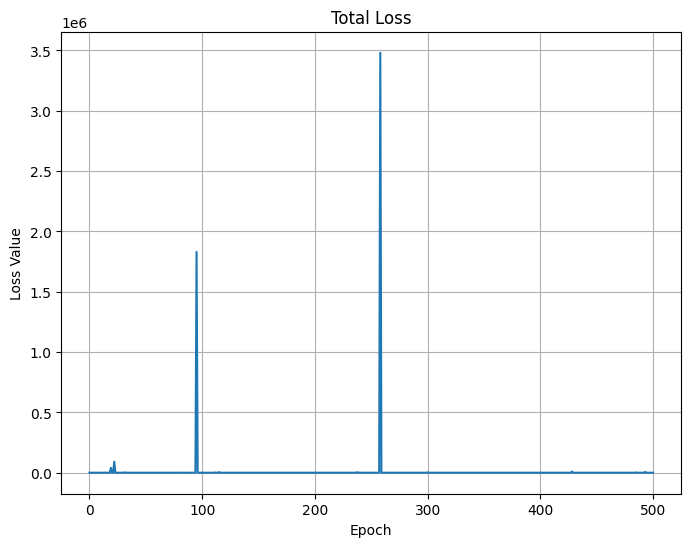

In [202]:
# Plot the final loss
plt.figure(figsize=(8, 6))
plt.plot(range(len(loss_values)), loss_values)
plt.title("Total Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss Value")
plt.grid(True)
plt.show()
